In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random

In [6]:
# Add path of your data on your local drive

df = pd.read_csv("train.csv")

In [7]:
# Clean input dataframe

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')

# Create minute column
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['dropoff_minutes'] = df['dropoff_datetime'].dt.minute

# Create hour column
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour

# Create day of week column
df['pickup_dow'] = df['pickup_datetime'].dt.weekday
df['dropoff_dow'] = df['dropoff_datetime'].dt.weekday

# Create day of month column
df['pickup_dom'] = df['pickup_datetime'].dt.day
df['dropoff_dom'] = df['dropoff_datetime'].dt.day

# Create month column
df['pickup_month'] = df['pickup_datetime'].dt.month
df['dropoff_month'] = df['dropoff_datetime'].dt.month

# Map 'Y' and 'N' in 'store_and_fwd_flag' as 1 and 0
store_and_fwd_map = {'Y':1,'N':0}
df = df.copy()
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(store_and_fwd_map)

In [21]:
# Create missing data
random.seed(123)

# Insert nan values in pickup_hour
nan_pickup_hours = df['pickup_hour'].sample(round(df.shape[0]/21)).index
df.loc[nan_pickup_hours,'pickup_hour']=np.nan

# Insert nan values in dropoff_longitude
nan_dropoff_longitude = df['dropoff_longitude'].sample(round(df.shape[0]/17)).index
df.loc[nan_dropoff_longitude,'dropoff_longitude']=np.nan

In [39]:
# Approach 1 - Delete rows with missing values
# Pass only the dataframe as argument

def approach1_rem_msg(messy_df):
    clean_df = messy_df.dropna()
    return clean_df

#------------------------------------------------------------------------------------------------------------------------

# Approach 2 - Impute missing values
# The following function imputes the missing values with mean/median/mode according to arguments passed
# User also has to pass as list the names of columns which have missing values 
# Call function  - approach2_impute_metric(<df>,<"mean">/<"median">/<"mode">,[<'missingcolname1'>,<'missingcolname2'])

def approach2_impute_metric(messy_df, metric, colnames):
    clean_df = messy_df.copy()
    if metric=="mean":
        for col in colnames:
            imputenum = round(messy_df[col].mean())
            clean_df[col] = messy_df[col].fillna(imputenum)
            
    if metric=="median":
        for col in colnames:
            imputenum = round(messy_df[col].median())
            clean_df[col] = messy_df[col].fillna(imputenum)
            
    if metric=="mode":
        for col in colnames:
            imputenum = messy_df[col].mode()
            clean_df[col] = messy_df[col].fillna(imputenum)
            
    return clean_df,
 
#-------------------------------------------------------------------------------------------------------------------------

# Approach 3 - Predict missing values
    
def approach3_predict_msg(messy_df, metric, colnames):
    
    X_df = messy_df.drop(colnames, axis = 1)
    Y_df = messy_df[colnames]
    Y_pred_df = pd.DataFrame(columns=colnames)
    
    for col in messy_df[colnames]:
    
        messy_df_train = messy_df[~messy_df[col].isnull()]
        msg_cols_train_df = messy_df_train[col]
        messy_df_train = messy_df_train.drop(colnames, axis = 1)

        messy_df_test = messy_df[messy_df[col].isnull()]
        msg_cols_test_df = messy_df_test[col]
        messy_df_test = messy_df_test.drop(colnames,axis = 1)

        Y_train = msg_cols_train_df.copy()
        X_train = messy_df_train.copy()
        
        if metric == "Linear Regression":
            model = LinearRegression()
            model.fit(X_train,Y_train)
            print("R-squared value is: " + str(model.score(X_train, Y_train)))
            
        elif metric == "Random Forests":
            model = RandomForestRegressor(n_estimators = 100 , oob_score = True)
            model.fit(X_train,Y_train) 
        
       
        
        X_test = messy_df_test.copy()
        Y_test = model.predict(X_test)
        
        Y_test_integer = pd.to_numeric(pd.Series(Y_test),downcast='integer')
        Y_complete = Y_train.append(Y_test_integer)
        Y_complete = Y_complete.reset_index(drop = True)
        
        Y_pred_df[col] = Y_complete
        Y_pred_df = Y_pred_df.reset_index(drop = True)
   
    clean_df = X_df.join(Y_pred_df)
    
    return clean_df

In [32]:
def accuracy_determination(df,algo, Y_col):
    y = df[Y_col]
    X = df.drop(Y_col, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    if algo == "Logistic Regression":
        model = LogisticRegression()
        model.fit(X_train,y_train)
    elif algo == "Random Forests":
        model = RandomForestClassifier(n_estimators = 100 , oob_score = True)
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [11]:
# Test the approaches to missing data

df_test = df.drop(['id','pickup_datetime','dropoff_datetime','trip_duration'], axis = 1)
df_test = df_test.head(1000)

# Call function to clean missing data

# Approach 1 - delete rows containing missing values 
test_pred1 = approach1_rem_msg(df_test)

# Approach 2 - Impute with mean/median/mode
test_pred2a = approach2_impute_metric(df_test,"mean",['dropoff_longitude','pickup_hour'])
test_pred2b = approach2_impute_metric(df_test,"median",['dropoff_longitude','pickup_hour'])
test_pred2c = approach2_impute_metric(df_test,"mode",['dropoff_longitude','pickup_hour'])

# Approach 3 - Predict missing value
test_pred3a = approach3_predict_msg(df_test,"Linear Regression",['dropoff_longitude','pickup_hour'])
test_pred3b = approach3_predict_msg(df_test,"Random Forests",['dropoff_longitude','pickup_hour'])

R-squared value is: 0.179724433829
R-squared value is: 0.987720419275


In [40]:
round(test_pred2a['pickup_hour'].mean())

14

In [12]:
# Compare missing value replacement approaches 

In [64]:
df2 = df.loc[:100000,:]
trip_duration_cutoff_mins = 20
df2['trip_duration_encoded'] = 0
df2.loc[df2['trip_duration']>=trip_duration_cutoff_mins*60,'trip_duration_encoded'] = 1
df2.loc[df2['trip_duration']<trip_duration_cutoff_mins*60,'trip_duration_encoded'] = 0
df2 = df2.drop(['id','pickup_datetime','dropoff_datetime','dropoff_minutes','dropoff_hour',
                'dropoff_dow','dropoff_dom','dropoff_month','trip_duration','dropoff_longitude','dropoff_latitude'], axis = 1)
df2.dropna(inplace=True);

/Users/sally/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sally/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [63]:
import time
a = time.time()

logistic_accuracy = accuracy_determination(df2,"Logistic Regression",'trip_duration_encoded')
print(logistic_accuracy)
rf_accuracy = accuracy_determination(df2,"Random Forests",'trip_duration_encoded')

print(rf_accuracy)
print(time.time()-a)

0.796263959864


KeyboardInterrupt: 

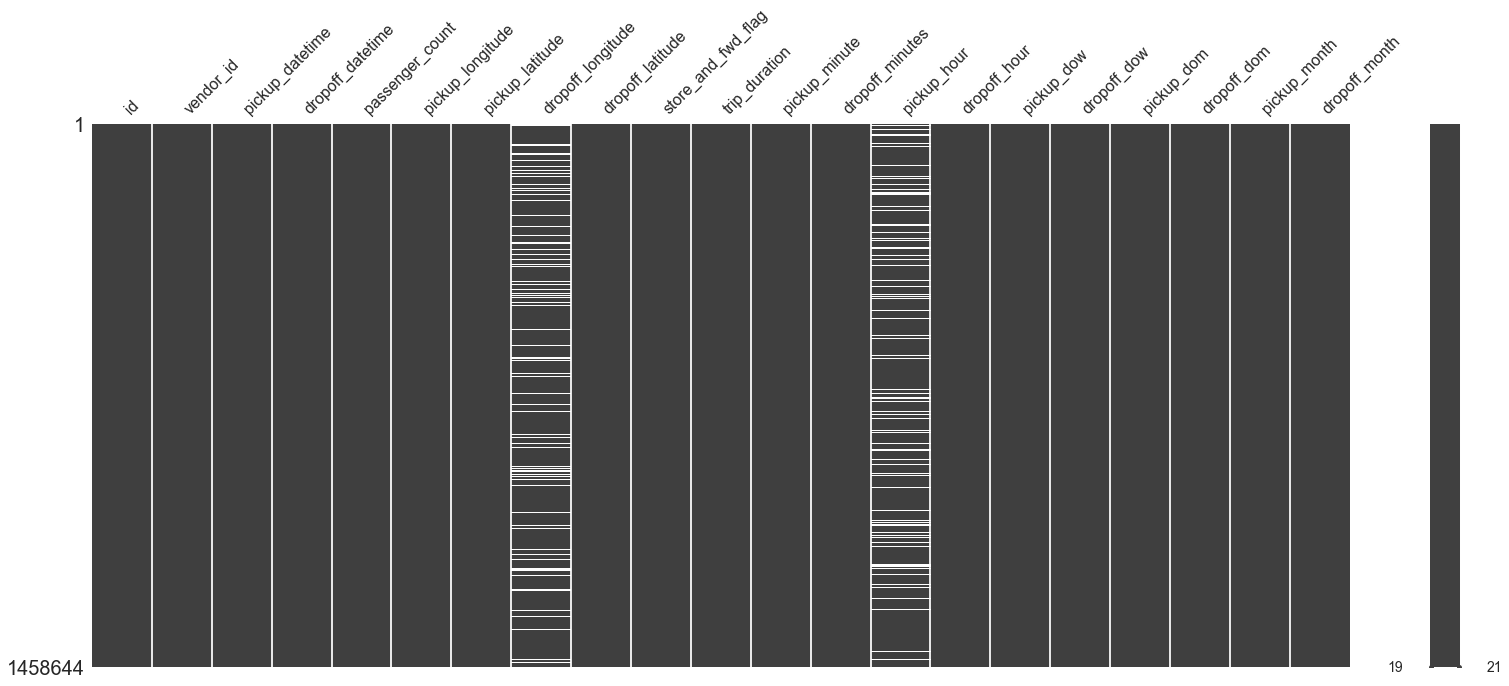

In [23]:
import missingno as msno
msno.matrix(df)

In [58]:
from ipywidgets import *
from IPython.display import display
from IPython.display import clear_output

# make 4 buttons
button1 = Button(description="Delete rows with missing values",
           layout=Layout(width='50%', height='50px'),)
button2 = Button(description="Impute metric: Mean",
                layout=Layout(width='50%', height='50px'))
button3 = Button(description="Impute metric: Median",
                layout=Layout(width='50%', height='50px'))
button4 = Button(description="Impute metric: Mode",
                layout=Layout(width='50%', height='50px'))
button5 = Button(description="Predict values: Linear Regression",
                layout=Layout(width='50%', height='50px'))
button6 = Button(description="Predict values: Random Forests",
                layout=Layout(width='50%', height='50px'))
display(button1, button2, button3, button4, button5, button6)

# define button calls

def button1Clicked(b):
    clear_output()
    msno.matrix(test_pred1)
    
def button2Clicked(b):
    clear_output()
    display(test_pred2)
    
def button3Clicked(b):
    clear_output()
    display(test_pred3)
        
def button4Clicked(b):
    clear_output()
    display(test_pred4)
    
# specify which functions to be called when buttons are clicked
button1.on_click(button1Clicked)
button2.on_click(button2Clicked)
button3.on_click(button3Clicked)
button4.on_click(button4Clicked)

In [69]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(test_pred2a['pickup_hour'])

test_pred2a.as_matrix(columns='pickup_hour')

TypeError: Index(...) must be called with a collection of some kind, 'pickup_hour' was passed

In [57]:
plt.hist(test_pred2a['pickup_hour'])

fig = plt.gcf()

plot_url = py.plot_mpl(fig, filename='mpl-basic-histogram')

NameError: name 'py' is not defined

In [ ]:
# Test code below - Do not run 6,7,10,16,17

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
character_cols = ['Origin','UniqueCarrier','Dest']

for col in character_cols:
    le.fit(X[col].values)
    X[col]=le.transform(X[col])

In [ ]:
sum(Y==1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 10 , oob_score = True)
model.fit(X,Y)

In [ ]:
model_features = pd.Series(model.feature_importances_,X.columns)
model_features.sort_values
model_features.plot(kind="barh",figsize=(7,6))

In [ ]:
model.feature_importances_